In [11]:
%matplotlib inline
from IPython.display import *
import ipywidgets as widgets
from hublib.ui import Submit
import numpy as np
from numpy import sqrt, sin, cos, pi, exp, log
import math
import scipy.integrate as integrate
import ahkab
import networkx as nx
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

## Composite Filament Simulation 3D

In [12]:
title = widgets.Label(value="Composite Filament 3D Tool", width=10)

box_layout = widgets.Layout(display='flex',
                            justify_content='center')
text_layout = widgets.Layout(width = '150px')
text_layout1 = widgets.Layout(width = '50px')
text_layout2 = widgets.Layout(width ='80px',
                              position = 'right')


input_diameter = widgets.BoundedFloatText(
    value=90.9,
    min=25,
    max=250,
    step=0.1,
    layout=text_layout2,
)

input_length = widgets.BoundedFloatText(
    value=20,
    step=0.1,
    min = 10,
    max = 25,
    layout=text_layout2,
)

# input_volume = widgets.BoundedFloatText(
#     value=1,
#     min=0.25,
#     max=10,
#     step=0.05,
#     layout=text_layout2,
# )

input_volume = widgets.SelectionRangeSlider(
    options=[1, 3, 5, 7, 9, 11],
    index=(0,5),
    disabled=False
)

input_alignment = widgets.BoundedFloatText(
    value=90,
    min=0,
    max=90,
    step=5,
    layout=text_layout2,
)

dia_label = widgets.Label("Nanowire diameter (nm):")
len_label = widgets.Label("Nanowire length (mm):")
vol_label = widgets.Label("% Volume of nanowires:")
ali_label = widgets.Label("Alignment range (degrees):")

vlabels = widgets.VBox([dia_label, len_label, vol_label, ali_label])
vinput = widgets.VBox([input_diameter, input_length, input_volume, input_alignment])

inputs2 = widgets.HBox([vlabels,vinput])
input1 = widgets.VBox([inputs2],layout=widgets.Layout(border='solid'))
FullBox = widgets.VBox([input1])

topic_list = ['Nanowire diameter']
topic_descriptions = ['Diameter of the nanowires, in nanometers.']

topic_dict = dict(zip(topic_list,topic_descriptions))

desc_layout1 = widgets.Layout(width = '280px')
desc_layout2 = widgets.Layout(width = '280px',
                             height = '400px'
)

#topic menu for descriptions
topic_widg = widgets.Dropdown(
    options=topic_list,
    description='Topic:',
    layout = desc_layout1,
)

#descriptions for each topic
topicdesc_widg = widgets.Textarea(
    value=topic_dict[topic_widg.value],
    layout = desc_layout2,
)

descriptions = widgets.VBox([topic_widg,topicdesc_widg])

In [13]:
#display(title)
tab_view = widgets.Tab()
tab_view.children = [FullBox,descriptions]
tab_view.set_title(0, 'Input Parameters')
tab_view.set_title(1, 'Input Descriptions')
display(tab_view)

Tab(children=(VBox(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Nanowire diameter (nm):'), Label(value='Nanowire length (mm):'), Label(value='% Volume of nanowires:'), Label(value='Alignment range (degrees):'))), VBox(children=(BoundedFloatText(value=90.9, layout=Layout(width='80px'), max=250.0, min=25.0, step=0.1), BoundedFloatText(value=20.0, layout=Layout(width='80px'), max=25.0, min=10.0, step=0.1), SelectionRangeSlider(index=(0, 5), options=(1, 3, 5, 7, 9, 11), value=(1, 11)), BoundedFloatText(value=90.0, layout=Layout(width='80px'), max=90.0, step=5.0))))),), layout=Layout(border='solid')),)), VBox(children=(Dropdown(description='Topic:', layout=Layout(width='280px'), options=('Nanowire diameter',), value='Nanowire diameter'), Textarea(value='Diameter of the nanowires, in nanometers.', layout=Layout(height='400px', width='280px'))))), _titles={'0': 'Input Parameters', '1': 'Input Descriptions'})

In [14]:
# Core Functions
"""Distance returns the 3D distance between line1=(start1, end1) and
line2=(start2, end2)."""
def distance(line1, line2):
    P = np.array(line1[0])
    Q = np.array(line1[1])
    R = np.array(line2[0])
    S = np.array(line2[1])
    P1mP0 = Q - P
    Q1mQ0 = S - R
    P0mQ0 = P - R
    a = np.dot(P1mP0, P1mP0)
    b = np.dot(P1mP0, Q1mQ0)
    c = np.dot(Q1mQ0, Q1mQ0)         
    d = np.dot(P1mP0, P0mQ0)
    e= np.dot(Q1mQ0, P0mQ0)
    det = a * c - b * b
    if det > 0:
        bte = b * e
        ctd = c * d
        if bte <= ctd: # s <= 0
            s = 0
            if e <= 0:  # t <= 0
                t = 0
                nd = -d
                if nd >= a:
                    s = 1
                elif nd > 0:
                    s = nd / a
            elif e < c:  #0 < t < 1 and region 5
                t = e / c
            else: # t >= 1
                t = 1   # region 4
                bmd = b - d
                if bmd >= a:
                    s = 1
                elif bmd > 0:
                    s = bmd / a
        else: 
            s = bte - ctd
            if s >= det:
                s = 1
                bpe = b + e
                if bpe <= 0: # region 8
                    t = 0
                    nd = -d
                    if nd <= 0:
                        s = 0
                    elif nd < a:
                        s = nd / a
                elif bpe < c: # region 1
                    t = bpe / c
                else: # region 2
                    t = 1
                    bmd = b- d
                    if bmd <= 0:
                        s = 0
                    elif bmd < a:
                        s = bmd / a
            else:
                ate = a * e
                btd = b * d
                if ate <= btd: # region 7 
                    t = 0
                    nd = -d
                    if nd <= 0:
                        s = 0
                    elif nd >= a:
                        s = 1
                    else:
                        s = nd / a
                else: 
                    t = ate - btd
                    if t >= det: # region 3
                        t = 1
                        bmd = b - d
                        if bmd <= 0:
                            s = 0
                        elif bmd >= a:
                            s = 1
                        else:
                            s = bmd / a
                    else:  # region 0
                        s /= det
                        t /= det
    else: 
        if e <= 0:
            t = 0
            nd = -d
            if nd <= 0: # region 6
                s = 0
            elif nd >=a: # region 8
                s = 1
            else: # region 7
                s = nd / a
        elif e >= c:
            t = 1
            bmd = b - d
            if bmd <= 0: # reigon 4
                s = 0
            elif bmd >= a: # region 2
                s = 1
            else:  # region 3
                s = bmd / a
        else:       
            """The point (0,e/c) is on the line and domain, so we have one
            point at which R is a minimum."""
            s = 0
            t = e / c

    result_parameter = [s, t]
    result_closest = [P + s * P1mP0, R + t * Q1mQ0]
    diff = result_closest[1] - result_closest[0]
    dist = np.dot(diff, diff)
    dist = math.sqrt(dist)
  
    return dist
  
"""Compute the euclidian distance between p1=(x1,y1,z1) and p2=(x2,y2,z2).""" 
def simple_distance(p1, p2):
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    z1 = p1[2]
    z2 = p2[2]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)

"""Returns volume of polymer given width(of square side) and length."""
def get_polymer_volume(width_of_poly, length_of_poly):
    return (width_of_poly ** 2) * length_of_poly

"""Returns volume of cylindrical nanowire with diameter and length."""
def get_wire_volume(length, diameter):
    return math.pi * ((diameter / 2) ** 2) * length
  
"""Returns a random point within the domain. """ 
def get_initial_point(width_of_poly, length_of_poly):
    x = np.random.uniform(-(width_of_poly / 2), (width_of_poly / 2))
    y = np.random.uniform(0, length_of_poly)
    z = np.random.uniform(0, width_of_poly)
    return (x, y, z)

def get_radians(degrees):
    return (degrees * math.pi) / 180

def get_phi(phi_lower, phi_upper):
    if np.random.rand() >= 0.5:
        return np.random.uniform(phi_lower, phi_upper)
    else:
        return np.random.uniform(-math.pi + phi_lower, -math.pi + phi_upper)
    
def get_theta(theta_lower, theta_upper):
    if np.random.rand() >= 0.5:
        return np.random.uniform(theta_lower, theta_upper)
    else:
        return np.random.uniform(-math.pi + theta_lower, -math.pi + theta_upper)
    
"""Returns an end point for the corresponding start_point within the domain. """
def get_end_point(p, mean, sd, phi_lower, phi_upper, theta_lower, theta_upper, width_of_poly, length_of_poly):
    length = np.random.normal(mean, sd)
    phi = get_phi(phi_lower, phi_upper) 
    theta = verti_angle = get_theta(theta_lower, theta_upper) 
    x = p[0] + length * math.sin((math.pi / 2) - phi) * math.cos((math.pi / 2) - theta)
    y = p[1] + length * math.sin((math.pi / 2) - phi) * math.sin((math.pi / 2) - theta)
    z = p[2] + length * math.cos((math.pi / 2) - phi)
    p_end = fix_domain(p, [x, y, z], -width_of_poly / 2, width_of_poly / 2, 0, length_of_poly, 0, width_of_poly)
    final_length = simple_distance(p, p_end)
    return tuple(p_end), final_length
  
"""Returns True if the line (point1, point2) has a distamce that is 
   greater than or equal to diameter away from all the lines defined by
   start_points, end_points."""  
def check_intersection(lines, point1, point2, diameter, int_tol):
    for line in lines:
        dist = distance(line, (point1, point2))
        if dist < diameter - int_tol:
            return False
    return True

"""Return True if the points (x, y, z) is not within the polymer. """
def check_domain(p):
    return p[1] > length_of_poly or p[2] > width_of_poly or p[2] < 0 \
                or abs(p[0]) > (width_of_poly / 2)

"""Given initial point p0 and a line (p0, p1), adjust p1 so it lies 
   within the domain x_lo, x_up, y_lo, y_up, z_lo, z_up."""
def fix_domain(p0, p1, x_lo, x_up, y_lo, y_up, z_lo, z_up):
    p0 = list(p0)
    p1 = list(p1)
    a = p1[0]-p0[0]
    b = p1[1]-p0[1]
    c = p1[2]-p0[2]
    if p1[0] > x_up:
        p1[0] = x_up
        t = (p1[0]-p0[0])/a
        p1[1] = p0[1] + t*b
        p1[2] = p0[2] + t*c
    elif p1[0] < x_lo:
        p1[0] = x_lo
        t = (p1[0]-p0[0])/a
        p1[1] = p0[1] + t*b
        p1[2] = p0[2] + t*c
    if p1[1] > y_up:
        p1[1] = y_up
        t = (p1[1]-p0[1])/b
        p1[0] = p0[0] + t*a
        p1[2] = p0[2] + t*c
    elif p1[1] < y_lo:
        p1[1] = y_lo
        t = (p1[1]-p0[1])/b
        p1[0] = p0[0] + t*a
        p1[2] = p0[2] + t*c  
    if p1[2] > z_up:
        p1[2] = z_up
        t = (p1[2]-p0[2])/c
        p1[0] = p0[0] + t*a
        p1[1] = p0[1] + t*b
    elif p1[2] < z_lo:
        p1[2] = z_lo
        t = (p1[2]-p0[2])/c
        p1[0] = p0[0] + t*a
        p1[1] = p0[1] + t*b
    return tuple(p1)
  
def get_cross_sectional_area(diameter):
    return (diameter / 2) ** 2 * math.pi
    
"""Returns a length=NUM_SUBSECTIONS list of list of lines where each line is [(x1, y1, z1), (x2, y2, z2)]."""
def generate(volume_fraction, width_of_poly, length_of_poly, diameter, 
            mean_nanowire_length, SD, theta_lower, 
            theta_upper, phi_lower, phi_upper, int_tol):
    volume_of_poly = get_polymer_volume(width_of_poly, length_of_poly)
    lines = []
    volume = 0
    while (volume / volume_of_poly) < volume_fraction:
        start = get_initial_point(width_of_poly, length_of_poly)
        end, length = get_end_point(start, mean_nanowire_length, SD, phi_lower, phi_upper, 
                                    theta_lower, theta_upper, width_of_poly, length_of_poly)
        while (int_tol != diameter and not check_intersection(lines, start, end, diameter, int_tol)):
            start = get_initial_point(width_of_poly, length_of_poly)
            end, length = get_end_point(start, mean_nanowire_length, SD, phi_lower, phi_upper, 
                                        theta_lower, theta_upper, width_of_poly, length_of_poly)
        # Enforce ordering of y values.
        if start[1] <= end[1]:
            lines.append([start, end])
        else:
            lines.append([end, start])
        volume += math.pi * ((diameter / 2) ** 2) * length
        #if len(lines) % 100 == 0:
            #print("Generated %d lines" % (len(lines)))
    return lines
    
def chop(lines, num_subsections, length_of_poly, width_of_poly):
    # Divide the lines along number of subsections.
    subsections = dict()
    for i in range(num_subsections):
        subsections[i] = []
    for lin in lines:
        y1 = lin[0][1]
        y2 = lin[1][1]
        assert(y1 <= y2)
        sublength = length_of_poly/num_subsections
        for i in range(num_subsections):
            cond = False
            if i == num_subsections - 1:
                cond = y2 >= sublength*i and y2 <= sublength*(i+1)
            else:
                cond = (y1 >= sublength*i and y1 < sublength*(i+1)) or \
               (y2 >= sublength*i and y2 < sublength*(i+1)) or \
               (y1 < sublength*i and y2 > sublength*(i+1))
            if cond:  
                p0 = lin[0]
                p1 = lin[1]
                p1 = fix_domain(p0, p1, -width_of_poly / 2, width_of_poly / 2, sublength*i, sublength*(i+1), 0, width_of_poly)
                p0 = fix_domain(p1, p0, -width_of_poly / 2, width_of_poly / 2, sublength*i, sublength*(i+1), 0, width_of_poly)
                subsections[i].append([p0, p1])
    ret_val = []
    for i in subsections:
        ret_val.append(subsections[i])
    return ret_val


def clamppoint(point, line):
    x = np.array(line[0])
    y = np.array(line[1])
    point = np.array(point)
    clamped_point = [0, 0, 0]
    if x[0] <= y[0]:
        minX = x[0]
        maxX = y[0]
    else:
        minX = y[0]
        maxX = x[0]
    if x[1] <= y[1]:
        minY = x[1]
        maxY = y[1]
    else:
        minY = y[1]
        maxY = x[1]    
    if x[2] <= y[2]:
        minZ = x[2]
        maxZ = y[2]
    else:
        minZ = y[2]
        maxZ = x[2]
    if point[0] < minX:
        clamped_point[0] = minX
    else:
        if point[0] > maxX:
            clamped_point[0] = maxX
        else:
            clamped_point[0] = point[0]
    if point[1] < minY:
        clamped_point[1] = minY
    else:
        if point[1] > maxY:
            clamped_point[1] = maxY
        else:
            clamped_point[1] = point[1]
    if point[2] < minZ:
        clamped_point[2] = minZ
    else:
        if point[2] > maxZ:
            clamped_point[2] = maxZ
        else:
            clamped_point[2] = point[2]
    return tuple(clamped_point)

def distBetweenLines(line1, line2):
    p1 = np.array(line1[0])
    p2 = np.array(line1[1])
    p3 = np.array(line2[0])
    p4 = np.array(line2[1])
    d1 = p2 - p1
    d2 = p4 - p3
    eq1nCoeff = np.dot(d1, d2)
    eq1mCoeff = (-(d1[0] ** 2)) - (d1[1] ** 2) - (d1[2] ** 2)
    eq1Const = ((d1[0] * p3[0]) - (d1[0] * p1[0]) + (d1[1] * p3[1]) - (d1[1] * p1[1]) + (d1[2] * p3[2]) - (d1[2] * p1[2]))
    eq2nCoeff = (d2[0] ** 2) + (d2[1] ** 2) + (d2[2] ** 2)
    eq2mCoeff = -(d1[0] * d2[0]) - (d1[1] * d2[1]) - (d1[2] * d2[2]);
    eq2Const = ((d2[0] * p3[0]) - (d2[0] * p1[0]) + (d2[1] * p3[1]) - (d2[1] * p1[1]) + (d2[2] * p3[2]) - (d2[2] * p1[2]))
    M = [[ eq1nCoeff, eq1mCoeff, -eq1Const ], [ eq2nCoeff, eq2mCoeff, -eq2Const ]]
    a = np.array([[eq1nCoeff, eq1mCoeff], [eq2nCoeff, eq2mCoeff]])
    #for parallel lines
    if np.linalg.det(a) == 0:
        return [p1, p3]
    b = np.array([-eq1Const, -eq2Const])
    x = np.linalg.solve(a,b)
    n = x[0]
    m = x[1]
    i1 = [p1[0] + (m * d1[0]), p1[1] + (m * d1[1]), p1[2] + (m * d1[2])]
    i2 = [p3[0] + (n * d2[0]), p3[1] + (n * d2[1]), p3[2] + (n * d2[2])]
    i1clamped = clamppoint(i1, line1)
    i2clamped = clamppoint(i2, line2)
    return (i1clamped, i2clamped)

""" Returns a networkx graph G formed from V = the lines in format 
 [(x1, y1, z1), (x2, y2, z2)] and E = distances between the lines
 that are within tolerance. Also returns a modified ordered lines with 
 format [endpoint1, endpoint2, (p1, n1), ...] where p1 is an 
 intersection point with line n.
"""
def init_graph(lines, tolerance):
    print("init_graph")
    G = nx.Graph()
    G.add_nodes_from(range(len(lines)))
    lineswi = list(lines) # Lines with intersection
    for i in range(len(lines)):
        for j in range(i):
            l1 = lines[i]
            l2 = lines[j]
            d = distance(l1, l2)
            if d <= tolerance:
                G.add_edge(i, j, weight=d*1e-6)  # Units unscaled
                p = distBetweenLines(l1, l2)
                lines[i].append((p[0], j))
                lines[j].append((p[1], i))
    return G, lineswi

def is_between(b1, x, b2):
     return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)

""" Given the length of the cross-section, a list of segments 
 [(x1, x2), (y1, y2), (z1, z2)], and graph G return a 
 connecting cluster from source(y~0) to sink(y~length). If none, 
 return None. 
"""
def find_connecting_cluster(segs, G, source_plane, sink_plane):
    print("find_connecting_cluster")
    n = range(len(segs))
    source_segs = [i for i in n if segs[i][1][0] == source_plane or 
                                   segs[i][1][1] == source_plane]
    sink_segs = [i for i in n if segs[i][1][0] == sink_plane or 
                                 segs[i][1][1] == sink_plane]
  
    if not source_segs or not sink_segs:
        print("No nanotubes intersecting source and/or sink planes.")
        return None, None, None
  
    # Iteratively grow the connecting cluster beginning from the source.
    H = nx.Graph()
    H.add_nodes_from(source_segs)
    new_segs = source_segs
    while new_segs:
        temp = list(new_segs)
        new_segs = []
        for seg in temp:
            for v in G.neighbors(seg):
                if v not in sink_segs and v not in H.nodes():
                    new_segs.append(v)
                H.add_edge(seg, v, weight=G[seg][v]['weight'])  
  
    # Iteratively grow from the sink to get the final cluster.
    K = nx.Graph()
    K_sinks, K_sources = set(), set()
    new_segs = [v for v in H.nodes() if v in sink_segs]
    K_sinks = set(new_segs)
    K.add_nodes_from(new_segs)
    path_exists = False
    while new_segs:
        temp = list(new_segs)
        new_segs = []
        for seg in temp:
            for v in H.neighbors(seg):
                if v not in source_segs and v not in K.nodes():
                    new_segs.append(v)
                if v in source_segs:
                    K_sources.add(v)
                K.add_edge(seg, v, weight=G[seg][v]['weight'])  
    for s in source_segs:
        if s in sink_segs:
            K.add_node(s)
            K_sources.add(s)
            K_sinks.add(s)
    if not K_sources:
        return None, None, None
    #print("SUCCESS. There are %d nanowires in the cluster out of all %d nanowires." % (len(K.nodes()), len(segs)))
    return K, K_sources, K_sinks


# Continue generating new until a connecting cluster can be found, up to LIMIT times
def repeat_generation(volume_fraction, width_of_poly, length_of_poly, diameter, 
            mean_nanowire_length, SD, theta_lower, 
            theta_upper, phi_lower, phi_upper, int_tol, limit, num_subsections_list):
#     print("Args to repeat_generation: ", volume_fraction, width_of_poly, length_of_poly, diameter, 
#             mean_nanowire_length, SD, theta_lower, 
#             theta_upper, phi_lower, phi_upper, int_tol, limit, num_subsections_list)
    num_failures = 0
    success = False
    lineswi_dict = dict()
    segments_dict = dict()
    K_dict = dict()
    K_sources_dict= dict()
    K_sinks_dict = dict()
    while num_failures < limit and not success:
        lineswi_dict = dict()
        segments_dict = dict()
        K_dict = dict()
        K_sources_dict= dict()
        K_sinks_dict = dict()
        t0 = time.time()
        lines = generate(volume_fraction, width_of_poly, 
                                           length_of_poly, diameter, 
                                           mean_nanowire_length, 
                                           SD, theta_lower, theta_upper, 
                                           phi_lower, phi_upper, 
                                           int_tol)
        t1 = time.time()
        H, lineswi = init_graph(lines, diameter*1) 
        segments = []
        for line in lines:
            x = [line[0][0], line[1][0]]
            y = [line[0][1], line[1][1]]
            z = [line[0][2], line[1][2]]
            segments.append([x, y, z])
        #-------------Graph Stuff--------------

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim3d(-width_of_poly/2, width_of_poly/2)
        ax.set_ylim3d(0, length_of_poly)
        ax.set_zlim3d(0, length_of_poly)  

        for seg in segments:
            ax.plot(seg[0], seg[1], seg[2])

        plt.xlabel('x')
        plt.ylabel('y')  
        plt.title('Composite Model %d for volume fraction %.5f' % (num_failures, volume_fraction))
        plt.show()  
        #------------End Graph Stuff-----------
        t2 = time.time()
        K, K_sources, K_sinks = find_connecting_cluster(segments, H, 0, length_of_poly)
        
        if not K:
            num_failures += 1
            print("Count(number of failed attempts) is ", num_failures)
            continue
            
        for num_subsections in num_subsections_list:
            #print("Calling chop cluster on %i sections" % (num_subsections))
            #print("Number of wires with no chopping: ", len(lines))
            lineswi_list, segments_list, K_list, K_sources_list, K_sinks_list = \
                chop_and_cluster(lines, num_subsections, length_of_poly, width_of_poly, diameter)
            lineswi_dict[num_subsections] = lineswi_list
            segments_dict[num_subsections] = segments_list
            K_dict[num_subsections] = K_list
            K_sources_dict[num_subsections] = K_sources_list
            K_sinks_dict[num_subsections] = K_sinks_list
            success = True
        t3 = time.time()
    print("Time to generate wires: %f.\nTime to init graph: %f.\nTime to find connecting cluster: %f."
         % (t1-t0, t2-t1, t3-t2))
    if num_failures == limit:
        print("No connecting paths despite repeating %d times." % (num_failures))
#         return None, None, None, None, None, None, None, None
    return lineswi_dict, segments_dict, K_dict, K_sources_dict, K_sinks_dict

def chop_and_cluster(lines, num_subsections, length_of_poly, width_of_poly, diameter):
#     print("clustering")
    lineswi_list = []
    segments_list = []
    K_list = []
    K_sources_list = []
    K_sinks_list = []
    subsections = chop(lines, num_subsections, length_of_poly, width_of_poly)
    for lines, i in zip(subsections, range(num_subsections)):
        H, lineswi = init_graph(lines, diameter*1) 
        segments = []
        #print("len(lines) for the %ith subsection for chopping of %i subsections: %i" % (i, num_subsections, len(lines)))
        for line in lines:
            x = [line[0][0], line[1][0]]
            y = [line[0][1], line[1][1]]
            z = [line[0][2], line[1][2]]
            segments.append([x, y, z])
        #print(len(segments))    
        sublength = length_of_poly/num_subsections
        K, K_sources, K_sinks = find_connecting_cluster(segments, H, sublength*i, sublength*(i+1)) #TODO: modify this function
        #K, K_sources, K_sinks = None, None, None
        assert(K)
        lineswi_list.append(lineswi)
        segments_list.append(segments)
        K_list.append(K)
        K_sources_list.append(K_sources)
        K_sinks_list.append(K_sinks)

    return lineswi_list, segments_list, K_list, K_sources_list, K_sinks_list  


# Process lineswi where each element is [endpoint1, endpoint2, (p1, n1), (p2, n2)...]
# to a dictionary {line#: [d1, (p1, n1), d2, (p2, n2), d3]} by ordering the intersection points.
def process_intersection_points(lineswi):
    lineswlen = dict()
    for elem, i in zip(lineswi, range(len(lineswi))):
        intersections_w_dist = []
        p0 = elem[0]
        p1 = elem[1]
        b = p1[1]-p0[1]
        with_weights = []
        for point, linenum in elem[2:]:
            weight = (point[1]-p0[1])/b
            with_weights.append(((point, linenum), weight))
        intersections_ordered = sorted(with_weights, key=lambda x: x[1])
        last_point = p0
        for item in intersections_ordered:
            p = item[0][0]
            subdivided_dist = simple_distance(last_point, p)
            intersections_w_dist.append(subdivided_dist)
            intersections_w_dist.append(item[0])                           
            last_point = p
        intersections_w_dist.append(simple_distance(last_point, p1))
        lineswlen[i] = intersections_w_dist
    assert(len(lineswi) == len(lineswlen)) # Sanity check
    return lineswlen

# cond_g is the conductivity in presence of both GBS and BS
# lambda_0 is background mean free path
# a is nanowire radius
# p is proportion of elastically scattered electrons
# v is the velocity vector magnitude
# r is the radius vector
# alpha is the 
# d = D is the avg grain diameter
# R is the reflection probability of an electron at a single plane.

def total_conductivity(a, lambda_0, R, d, theta, cond_0, p):
    # C = D/(2*a) = 1
    k = 2*a/lambda_0
    t = 1/sin(theta)
    alpha = (lambda_0/d)*(R/(1-R))
    cond_g = 3*cond_0*(1/3 - .5*alpha + alpha**2 - alpha**3*log(1 + 1/alpha))
    H = 1 + alpha/(1-1/t**2)**.5
    f1 = lambda t : (-1/(H)**2)*(t**-5)*sqrt(t**2 - 1)
    integral_1 = integrate.quad(f1, 1, np.inf) 
    # Approximate the geometric series
    def sum_of_series(max):
        total = 0
        for v in range(max):
            f2 = lambda psi : (exp(-(v+1)*H*k*t*sin(psi)) - exp(-v*H*k*t*sin(psi)))*sin(psi)
            integral_2 = integrate.quad(f2, 0, pi/2)
            total = total + p**v * integral_2[0]
        return total
    total_cond = cond_g - (12/(pi*k))*(1-p)*integral_1[0]*sum_of_series(10)
    return total_cond

def calc_resistance(total_cond, cross_sectional_area, length):
    resistivity = 1 / total_cond
    resistance = (resistivity * length) / cross_sectional_area
    return resistance

def calc_resistvity(R, cross_sectional_area, length):
    return R*cross_sectional_area/length


# Compute the length of the segment [(x1, x2), (y1, y2), (z1, z2)].
def get_length(seg):
    x1 = seg[0][0]
    x2 = seg[0][1]
    y1 = seg[1][0]
    y2 = seg[1][1]
    z1 = seg[2][0]
    z2 = seg[2][1] 
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    

# Given the connecting cluster K, runs spice on the graph. LINESWLEN is a dict 
# {line#: [d1, (p1, n1), d2, (p2, n2), d3]} where p# are intersecting points and 
# n# is the line number.
def simulate_circuit(K, lineswlen, source_nodes, sink_nodes, diameter, segments, source_voltage):
    #print("sink nodes:", sink_nodes)
    # First, create a dict where each element represents a wire and contains its
    # nodes and subdivided lengths. For example, value = [1a, d1, {1, 123}, d2, sink].
    # Endpoints are either #a, #b, source, or gnd. Set pairs are unordered.
    # Inner nodes are size 2 of sets, representing which wires are intersecting.
    wireswnodes = dict()
    for node in K:
        wirevalue = []
        if node in source_nodes:
            wirevalue.append('source')
        else:
            wirevalue.append(str(node) + 'a')
        wiredata = lineswlen[node]
        for item in wiredata:
            if not isinstance(item, tuple):
                wirevalue.append(item)
            else:
                if node < item[1]:
                    wirevalue.append(str(node) + "-" + str(item[1]))
                else:
                    wirevalue.append(str(item[1])+ "-" + str(node))
        if node in sink_nodes:
            wirevalue.append('gnd')
        else:
            wirevalue.append(str(node) + 'b')
        assert(len(wirevalue) >= 3 and len(wirevalue)%2 == 1) #Sanity check
        wireswnodes[node] = wirevalue
        
    # Next, create the circuit.
    Nodes = {}
    Wires = {}
    cir = ahkab.Circuit('Nanowire Composite Simulation w/ Resistors Only')
    cir.add_vsource('Vinput', 'source', cir.gnd, dc_value=5)   
    cond = total_conductivity(diameter*1e-6/2, diameter*1e-6, 0.3, diameter*1e-6, 1, 6.3e7, .4)
    for wire, value in wireswnodes.items():
        for i in range(0, len(value)-1, 2):
            r_name = str(wire)+"_"+str(int(i/2)) # Name resistors w#_s#, w# is wire and s# is section number of the wire.
            n1 = str(value[i])
            sublength = value[i+1]*1e-6
            subr = calc_resistance(cond, np.pi*(diameter/2)**2, sublength)
            n2 = str(value[i+2])
            if n2 == 'gnd' and (subr != 0):
                Wires[r_name] = [r_name, n1, cir.gnd, subr]
            else:
                if subr != 0:
                    Wires[r_name] = [r_name, n1, n2, subr]
            if n1 in Nodes and subr != 0:
                update = Nodes[n1]
                update.append(r_name)
            else:
                if subr != 0:
                    Nodes[n1] = [r_name]
            if n2 in Nodes and subr != 0:
                update = Nodes[n2]
                update.append(r_name)
            else:
                if subr != 0:
                    Nodes[n2] = [r_name]
    deletewires = []
    for node, wire_list in Nodes.items():
        if len(wire_list) == 1:
            wire_name = wire_list[0]
            wire = Wires[wire_name]
            if wire[1] == node:
                compare = wire[2]
            else: 
                compare = wire[1]
            if compare != 0 and len(Nodes[compare]) == 1:
                if wire_name not in deletewires:
                    deletewires.append(wire_name)
    
    for wire in deletewires:
        print("deleting eh", wire)
        del Wires[wire]
                
    for wire, wire_list in Wires.items():
        if wire_list[3] != 0:         
            cir.add_resistor(wire_list[0], wire_list[1], wire_list[2], value=wire_list[3])

    opa = ahkab.new_op()
    r = ahkab.run(cir, opa)['op']
    return r['I(VINPUT)'] * -1
    
# Return a pair (current, resistance) given currents of subsections.     
def process_current_list(current_dict, voltage_src):
    overall_curr_dict = dict()
    for key in current_dict:    
        current_list = current_dict[key]
        total_resistance = sum([voltage_src/current for  current in current_list])
        overall_curr_dict[key] = (voltage_src/total_resistance, total_resistance)
    return overall_curr_dict

# Return dictionary of overall resistvity.
def process_overall_resistance(width_of_poly, length_of_poly, overall_curr_dict):
    p = dict()
    for key in overall_curr_dict:
        cur, res = overall_curr_dict[key]
        p[key] = res*(width_of_poly)**2/length_of_poly
    return p

# Maps volume fraction to number of subsections.
def get_number_subsections(v):
    if v < .02:
        return 2
    if v < .05:
        return 4
    if v < .08:
        return 4
    return 4

# Maps volume fraction to domain size.
def get_domain_size(v):
    if v < .02:
        return 25
    if v < .05:
        return 25*0.5
    if v < .08:
        return 25*0.25
    return 25*0.25

In [15]:
def my_start(s):
   
    rname = s.make_rname([input_volume.value, input_length.value, 
                         input_diameter.value, input_alignment.value])
    vols, res = run_model()
   
    # What to pass in as submit_str?
    submit_str = '--local echo %s' % ("Simulation complete.")
    print("Overall resistivities: ", res)
    s.run(rname, submit_str)

In [16]:
def run_for_vol_fraction(volume_fraction):
   # print("arg1 is ", arg1, "arg 2 is ", arg2)
    #volume_fraction = input_volume.value/100
    mean_nanowire_length = input_length.value
    diameter = input_diameter.value*1e-3
    rad = get_radians(input_alignment.value)
    width_of_poly = get_domain_size(volume_fraction)
    length_of_poly = 25
    SD = .5
    theta_lower = -rad
    theta_upper = rad
    phi_lower = -rad
    phi_upper = rad
    cross_sectional_area = (diameter / 2) ** 2 * math.pi
    intersection_tolerance = diameter #Disregard intersections

# ----------Uncomment this chunk to get percolation true/false outputted.----------
#     num_subsections = 1 
#     lines = generate(volume_fraction, width_of_poly, 
#                      length_of_poly, diameter, 
#                      mean_nanowire_length, 
#                      SD, theta_lower, theta_upper, 
#                      phi_lower, phi_upper, 
#                      intersection_tolerance)
#     subsections = chop(lines, num_subsections, length_of_poly, width_of_poly) 
#     H, lineswi = init_graph(lines, diameter*1) 
#     segments = []
#     for line in lines:
#         x = [line[0][0], line[1][0]]
#         y = [line[0][1], line[1][1]]
#         z = [line[0][2], line[1][2]]
#         segments.append([x, y, z])


#     K, K_sources, K_sinks = find_connecting_cluster(segments, H, 0, length_of_poly)
#     path = str(bool(K))
#     return path
    
    num_subsections_list = [get_number_subsections(volume_fraction)]
    #num_subsections_list = [2]
    lineswi_dict, segments_dict, K_dict, K_sources_dict, K_sinks_dict = \
        repeat_generation(volume_fraction, width_of_poly, 
                                   length_of_poly, diameter, 
                                   mean_nanowire_length, 
                                   SD, theta_lower, theta_upper, 
                                   phi_lower, phi_upper, 
                                   intersection_tolerance, 10, num_subsections_list)
    lineswlen_dict = dict()
    for num_subsections in num_subsections_list:
        i = num_subsections
        lineswlen_list = [process_intersection_points(lineswi) for lineswi in lineswi_dict[i]]
        lineswlen_dict[i] = lineswlen_list
    #cond = total_conductivity(diameter*1e-6/2, diameter*1e-6, 0.3, diameter*1e-6, 1, 6.3e7, .4)
    voltage_src = 5
    r_list = []
    current_dict = dict()
    t0 = time.time()
    for num_subsections in num_subsections_list:
        i = num_subsections
        print("Calling simulate_circuit for %i subsections" % (i))
        current_list = [simulate_circuit(K, lineswlen, K_sources, K_sinks, diameter*1e-6, segments, voltage_src)
                   for K, lineswlen, K_sources, K_sinks, segments
                   in zip(K_dict[i], lineswlen_dict[i], K_sources_dict[i], K_sinks_dict[i], segments_dict[i])] 
        #print current_list[0]
        current_dict[i] = current_list
        curr_dict = process_current_list(current_dict, 5)
        r_list.append(curr_dict[i][1])
    t1 = time.time()
    print("Time to run circuit simulation: %f." % (t1-t0))
    overall_current = process_current_list(current_dict, voltage_src)
    overall_resistvitity = process_overall_resistance(width_of_poly, length_of_poly, overall_current)

    cur_result = str(overall_current[num_subsections_list[0]])
    res_result = overall_resistvitity[num_subsections_list[0]][0][0]
    print("Average resistance for %s percent after %s iterations is %s with a std of %s." % (volume_fraction, 1, np.mean(np.array(r_list)), np.std(np.array(r_list))))

    return res_result*1e-6
    #----------------------------------------------------------------------------------


In [17]:
def run_model():
#     print(run_for_vol_fraction(.01))
#     return None, None
    x_values = list(np.linspace(input_volume.value[0], input_volume.value[1]+1, 5))
    y_values = []
    
    init_time = time.time()
    for n in x_values:
        volume_fraction = n/100
        y_values.append(run_for_vol_fraction(volume_fraction))
        print("Ran volume fraction %.5f which took time %s" % (volume_fraction, time.time() - init_time))
        init_time = time.time()
    plt.plot(x_values, y_values)
    plt.xlabel('Volume %')
    plt.ylabel('Resistivity')
    return x_values, y_values


In [18]:
input_volume.value

(1, 11)

VBox(children=(Button(button_style='success', description='Run', style=ButtonStyle(), tooltip='Run Simulation'),), layout=Layout(flex_flow='column', justify_content='flex-start', width='auto'))

init_graph


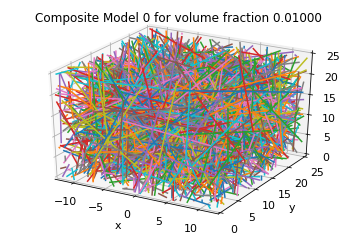

find_connecting_cluster
init_graph


In [19]:
Submit(start_func=my_start, cachename='SubmitTest', show_progress=True)

In [10]:
3.0163045662596357e-05

3.0163045662596357e-05